In [2]:
import cv2
import gc
from scipy.misc import imread
import numpy as np

from io import BytesIO
from glob import glob
import matplotlib.pyplot as plt
import scipy.io as sio
from plotly.offline import iplot
import plotly.graph_objs as go
import numpy as np
import warnings
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from keras.utils.np_utils import to_categorical
warnings.filterwarnings("ignore")

In [3]:
data = sio.loadmat('cars_annos.mat').get('annotations')[0]

In [4]:
class_names = [x.item() for x in sio.loadmat('cars_annos.mat').get('class_names')[0]]

car_make = [name.split()[0] for name in class_names]

make_map = dict(zip(range(len(car_make)),car_make))

num_make_classes = len(np.unique(car_make))

indices_map = dict(zip(np.unique(car_make),range(num_make_classes)))

In [5]:
class Image(np.ndarray):
    
    def __new__(cls,data):
        
        path = data[0].item()
        
        bbox_x1, bbox_y1, bbox_x2, bbox_y2 = list(data)[1:5]
        
        im = imread(path)[bbox_y1.item():bbox_y2.item(), bbox_x1.item():bbox_x2.item()]
        
        outlier_length = im.shape[0]<100 or im.shape[0]>665
        outlier_width  = im.shape[1]<100 or im.shape[1]>1137
        
        if outlier_length or outlier_width:
            return np.asarray([]).view(cls)
        else:
            return np.asarray(cv2.resize(im,(276,513))).view(cls)
    
    
    def __init__(self,data):
        
        self.path = data[0].item()
        
        self.valid = self.shape[-1] == 3 and len(self)!=0 #make sure it's a real photo (RGB = 3)
        
        self.label = data[5].item() - 1 # puts the type of the car in a tuple
        
        self.make_label = indices_map[make_map[self.label]]
        
        self.test = data[6].item() == True #if prediction of the label[6] is correct then True
        
        self.train = not self.test #incase test is False than Train is true (still needs training)

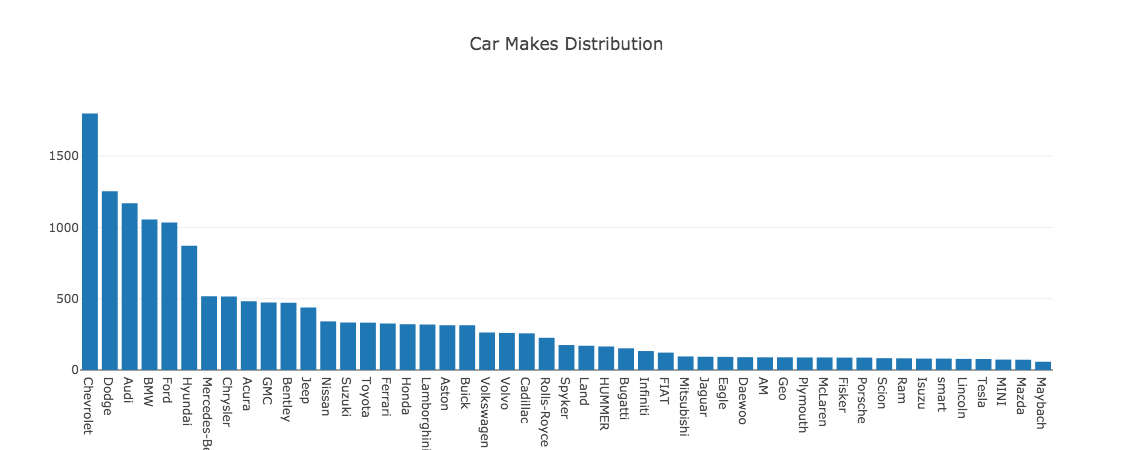

In [7]:
from collections import Counter
counts = Counter([make_map[x[5].item()-1] for x in data])
x,y = zip(*sorted(counts.items(),key=lambda x: x[1],reverse=True))

trace = go.Bar(x=x,y=y)
iplot({"data":[trace],"layout":go.Layout(title="Car Makes Distribution")})

In [13]:
from keras.utils import to_categorical

train_size = (7060, 513, 276, 3)    
test_size = (7071, 513, 276, 3)
num_classes = 196
make_classes = 49

x_train,x_test,y_train,y_test,y_train_make,y_test_make = [],[],[],[],[],[]

with ThreadPoolExecutor() as executor:
    for im in executor.map(Image,data):
        if im.valid is False: continue
            
        if im.train:
            x_train.append(im)
            y_train.append(to_categorical(im.label,num_classes))
            y_train_make.append(to_categorical(im.make_label,make_classes))
        else:
            x_test.append(im)
            y_test.append(to_categorical(im.label,num_classes))
            y_test_make.append(to_categorical(im.make_label,make_classes))

In [14]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_test  = np.array(y_test)
y_train  = np.array(y_train)
y_train_make = np.array(y_train_make)
y_test_make = np.array(y_test_make)

In [15]:
x_train = x_train/255.0
x_test = x_test/255.0       

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import *
from keras import backend as K


In [12]:
input_tensor = Input(shape=(513,276, 3))

base_model = InceptionResNetV2(input_tensor=input_tensor, pooling='avg',include_top=True)

outputs = Dense(num_classes, activation='softmax')(base_model.output) #attaching the model to the output the layer

model_exp1 = Model(base_model.inputs, outputs)


In [13]:
model_exp1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['top_k_categorical_accuracy']) #accuracy measure: predictsthe top 10 labels...

In [14]:
model_exp1.load_weights('weights.h5')

In [ ]:
for i in range(10):
    model_exp1.fit(x_train, y_train,batch_size=32,validation_data=(x_test,y_test), epochs=25)
    model_exp1.save_weights('weights.h5')

We will add train_dataagen that includes our data augmented.

In [17]:
train_datagen = ImageDataGenerator(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     shear_range=0.2,
                    horizontal_flip=True)

In [15]:
import gc
gc.collect()

0

I trained the Model in multiple phases.

In the first phase, I trained the model for 250 epochs on the the raw data without any augmentation. Essentially, my intentions was for the model to learn the underlying distrubtion regardless if it over fit the data. Upon evaluation, the model was overfitting as expected with top_5_categorrical_accuracy of 75% on the train test and %40 on the test set.

In the second stage, I created an Image Augmentation generator that samples images and applies random augmentations on them for every batch in every epoch. I trained the model for 1000 epochs. The model was robust enought and the gap between the train and test performance was diminished.

Finally, I finetuned the model on the raw trarin data again for few epochs since this will be the data it predicts in a real case scenarios. The final result was %97 top_5_categorical_accuracy on the train and %85 on the test set

hot epochs training!!


In [ ]:
for i in range(50):
    epochs = 25
    model_exp1.fit_generator(train_datagen.flow(x_train, y_train,batch_size=32),
                    steps_per_epoch=len(x_train) / 32,validation_data=(x_test,y_test), epochs=epochs)
    model_exp1.save_weights('weights.h5')

In [ ]:
model_exp1.fit(x_train, y_train,batch_size=32,validation_data=(x_test,y_test), epochs=5)

In [ ]:
#model.save_weights('weights.h5')

In [12]:
model_exp1.evaluate(x_train,y_train)

7060/7060 [==============================] - 84s 12ms/step


[2.2051053478089675, 0.9712464589235128]

In [239]:
model_exp1.evaluate(x_test,y_test)

7071/7071 [==============================] - 113s 16ms/step


[2.470687541137607, 0.8578701739836542]

predicts also the type and evaluate that.

In [16]:
labels_name = sio.loadmat('cars_annos.mat')['class_names'][0]
id_to_name_map = dict(zip(range(len(labels_name)), [x[0] for x in labels_name]))

In [ ]:
predictions_make_model = model_exp1.predict(x_test)

In [ ]:
import pandas as pd

In [ ]:
def top_k_accuracy(y_pred,y_true):
    dict_ = dict()
    y_true = np.array([np.argmax(val) for val in y_true])
    for n in range (1,6):
        top_n_pred = np.argsort(y_pred,axis=1)[:,-n:]
        i=0
        for pred_val,true_val in zip(top_n_pred, y_true):
            if true_val in pred_val:
                i+=1
                
        dict_['top_' + str(n) + '_accuracy'] = i/len(top_n_pred)
    
    return dict_


In [18]:
df = pd.DataFrame([top_k_accuracy(predictions_make_model,y_test)],index=["Car Make Model"])

In [19]:
df.head()

,top_1_accuracy,top_2_accuracy,top_3_accuracy,top_4_accuracy,top_5_accuracy
Car Make Model,0.42243,0.622401,0.745581,0.815443,0.85787


In [ ]:
top_4_pred = np.argsort(predictions_make_model,axis=1)[:,-4:]
top_4_pred = np.array([[id_to_name_map[pred][0] for pred in top_n] for top_n in top_4_pred])
y_true = np.array([id_to_name_map[np.argmax(val)][0] for val in y_test])

In [ ]:
label_id_map = {v[0]:k for k,v in id_to_name_map.items()}

In [ ]:
with ThreadPoolExecutor() as executor:
    images = list(executor.map(Image,data))

In [ ]:
from collections import defaultdict

In [ ]:
label_image_map = defaultdict(list)
for label_indice,image in zip(map(lambda im: im.label,images),images):
    if image.valid:
        label_image_map[label_indice].append(image)

In [ ]:
x_test_orig = [im for im in images if im.valid and im.train is False]

In [ ]:
import matplotlib.pyplot as plt
import random
rows, cols= 10, 5
plt.figure(figsize=(25, 35))
for row in range(rows):
    ix = random.choice(range(len(x_test))) #random choice variable of the array
    image = x_test_orig[ix]
    preds = top_4_pred[ix]
    
    for i,col in enumerate(range(len(preds)+1)):
        if i>0:
            plt.subplot(rows, cols, row * cols + col + 1)
            image = random.choice(label_image_map[label_id_map[preds[i-1]]])
            plt.imshow(cv2.resize(image,(300,300)))
            plt.title("pred {}: {}".format(i,preds[i-1]))
            plt.axis("off")
        else:
            plt.subplot(rows, cols, row * cols + col + 1)
            plt.imshow(cv2.resize(image,(300,300)))
            plt.title("True Label: {}".format(y_true[ix]))
            plt.axis("off")


### Train on car Make only (49 classes vs 196 classes)

In [8]:
from keras import regularizers

In [9]:
input_tensor = Input(shape=(513,276, 3))

base_model = InceptionResNetV2(input_tensor=input_tensor, pooling=None,include_top=False)

outputs = Dense(make_classes, W_regularizer=regularizers.l2(0.01))(GlobalAveragePooling2D()(base_model.output))

outputs = Activation('linear')(outputs)

model_exp2 = Model(base_model.inputs, outputs)

In [10]:
model_exp2.compile(loss='categorical_hinge',optimizer='adam',metrics=['top_k_categorical_accuracy'])

In [11]:
model_exp2.load_weights('make_weights.h5')

In [32]:
[layer.shape for layer in trained_w[:-5]] == [layer.shape for layer in w[:-3]]

True

In [31]:
w = model_exp2.get_weights()  #svm
trained_w = model_exp1.get_weights()

w = trained_w[:-5] + w[-3:]

model_exp2.set_weights(w)

In [ ]:
for i in range(50):
    model_exp2.fit(x_train, y_train_make,batch_size=32,validation_data=(x_test,y_test_make), epochs=20)
    model_exp2.save_weights('make_weights.h5')
    

In [63]:
train_datagen = ImageDataGenerator(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     shear_range=0.2,
                    horizontal_flip=True)

In [ ]:
for i in range(50):
    epochs = 25
    model_exp2.fit_generator(train_datagen.flow(x_train, y_train_make,batch_size=32),
                    steps_per_epoch=len(x_train) / 32,validation_data=(x_test,y_test_make), epochs=epochs)
    model_exp2.save_weights('make_weights.h5')
    

In [ ]:
model_exp2.load_weights('make_weights.h5')

In [23]:
y_pred = model_exp2.predict(x_train)

In [17]:
indices_map_reverse = {v:k for k,v in indices_map.items()}

In [24]:
y_true_make = [indices_map_reverse[np.argmax(x)] for x in y_train_make]

In [25]:
y_pred_make = [indices_map_reverse[np.argmax(x)] for x in y_pred]

In [38]:
np.unique(y_true_make)

array(['AM', 'Acura', 'Aston', 'Audi', 'BMW', 'Bentley', 'Bugatti',
       'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Daewoo', 'Dodge',
       'Eagle', 'FIAT', 'Ferrari', 'Fisker', 'Ford', 'GMC', 'Geo',
       'HUMMER', 'Honda', 'Hyundai', 'Infiniti', 'Isuzu', 'Jaguar',
       'Jeep', 'Lamborghini', 'Land', 'Lincoln', 'MINI', 'Maybach',
       'Mazda', 'McLaren', 'Mercedes-Benz', 'Mitsubishi', 'Nissan',
       'Plymouth', 'Porsche', 'Ram', 'Rolls-Royce', 'Scion', 'Spyker',
       'Suzuki', 'Tesla', 'Toyota', 'Volkswagen', 'Volvo', 'smart'],
      dtype='<U13')

In [20]:
from sklearn.metrics import confusion_matrix

In [26]:
cm = confusion_matrix(y_true_make,y_pred_make,labels=list(indices_map_reverse.values()))

In [ ]:
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

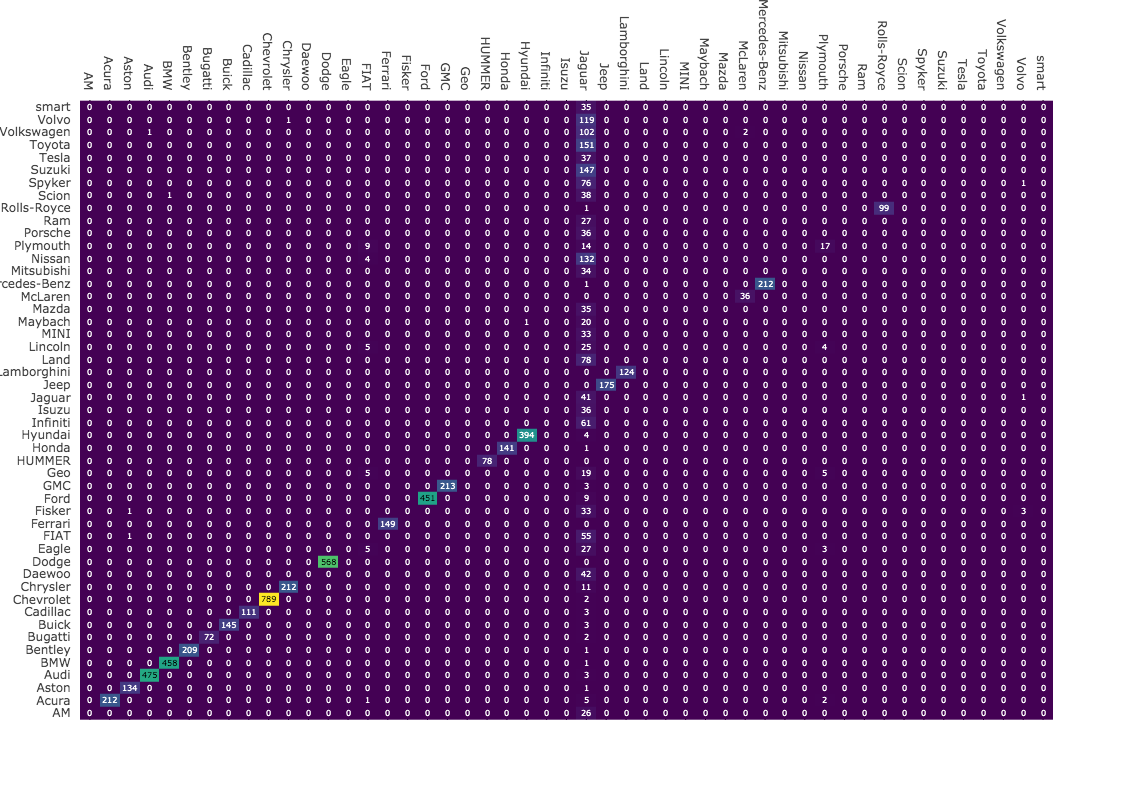

In [27]:
import plotly.figure_factory as ff


x = list(indices_map_reverse.values())
y = list(indices_map_reverse.values())


fig = ff.create_annotated_heatmap(np.round(cm,2), x=x, y=y, colorscale='Viridis')

for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 8
    
fig.layout.height=800
fig.layout.width=1200
iplot(fig)

In [28]:
from keras import optimizers

## Fine tuning Make

In [29]:
input_tensor = Input(shape=(513,276, 3))

base_model = InceptionResNetV2(input_tensor=input_tensor, pooling='avg',include_top=False)

outputs = Dense(128,kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001),
                activation='elu')(base_model.output)

dropout = Dropout(rate=0.2)(outputs)

outputs = Dense(64,kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001),activation='elu')(dropout)

dropout = Dropout(rate=0.2)(outputs)

outputs = Dense(make_classes,kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001), activation='softmax')(outputs) 

model_exp3 = Model(base_model.inputs, outputs)

model_exp3.compile(optimizer=optimizers.adam(lr=5e-4), loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [30]:
model_exp3.load_weights('softmax_make_model_finetuning.h5')

In [ ]:
model_exp3.fit(x_train, y_train_make,batch_size=32,validation_data=(x_test,y_test_make), epochs=20)

In [58]:
model_exp3.save_weights('softmax_make_model_finetuning.h5')

## Finetuning make model 

In [50]:
input_tensor = Input(shape=(513,276, 3))

base_model = InceptionResNetV2(input_tensor=input_tensor, pooling='avg',include_top=False)

outputs = Dense(128,kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001),
                activation='elu')(base_model.output)

dropout = Dropout(rate=0.4)(outputs)

outputs = Dense(64,kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001),activation='elu')(dropout)

dropout = Dropout(rate=0.4)(outputs)

outputs = Dense(256,kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001),activation='elu')(dropout)

dropout = Dropout(rate=0.4)(outputs)

outputs = Dense(num_classes,kernel_regularizer=regularizers.l2(0.001),
                activity_regularizer=regularizers.l2(0.001), activation='softmax')(dropout) 

model_exp4 = Model(base_model.inputs, outputs)

model_exp4.compile(optimizer=optimizers.adam(lr=5e-4), loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [51]:
model_exp4.load_weights('model_make_ft_weights.h5')

In [52]:
w1 = model_exp4.get_weights() 

trained_w = model_exp1.get_weights()
trained_make_w = model_exp2.get_weights()

In [ ]:
model_exp4.set_weights(trained_make_w[:-2] + w1[-4:-1] +trained_w[-1:])

In [ ]:
for i in range(5):
    model_exp4.fit(x_train, y_train,batch_size=30,validation_data=(x_test,y_test), epochs=20)
    model_exp4.save_weights('model_make_ft_weights.h5')

In [12]:
train_datagen = ImageDataGenerator(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     shear_range=0.2,
                    horizontal_flip=True)

In [54]:
model_exp4.save_weights('model_make_ft_weights.h5')

In [ ]:
for i in range(10):
    epochs = 10
    model_exp4.fit_generator(train_datagen.flow(x_train, y_train,batch_size=30),
                    steps_per_epoch=len(x_train) / 30,validation_data=(x_test,y_test), epochs=epochs)
    model_exp4.save_weights('model_make_ft_weights.h5')

Epoch 1/10
236/235 [==============================] - 293s 1s/step - loss: 2.4311 - categorical_accuracy: 0.9545 - val_loss: 2.2276 - val_categorical_accuracy: 0.7989
Epoch 2/10
236/235 [==============================] - 282s 1s/step - loss: 2.4386 - categorical_accuracy: 0.9508 - val_loss: 2.2226 - val_categorical_accuracy: 0.7945
Epoch 3/10
236/235 [==============================] - 281s 1s/step - loss: 2.4379 - categorical_accuracy: 0.9507 - val_loss: 2.2263 - val_categorical_accuracy: 0.7944
Epoch 4/10
236/235 [==============================] - 280s 1s/step - loss: 2.4463 - categorical_accuracy: 0.9479 - val_loss: 2.2094 - val_categorical_accuracy: 0.8027
Epoch 5/10
 14/235 [>.............................] - ETA: 2:19 - loss: 2.4131 - categorical_accuracy: 0.9571

In [32]:
model_exp4.load_weights('model_make_ft_weights.h5')

In [ ]:
for i in range(10):
    model_exp4.fit(x_train, y_train,batch_size=30,validation_data=(x_test,y_test), epochs=10)
    model_exp4.save_weights('model_make_ft_weights.h5')

Train on 7060 samples, validate on 7071 samples
Epoch 1/10
7060/7060 [==============================] - 218s 31ms/step - loss: 2.3987 - categorical_accuracy: 0.9688 - val_loss: 2.6862 - val_categorical_accuracy: 0.7961
Epoch 2/10
7060/7060 [==============================] - 218s 31ms/step - loss: 2.3795 - categorical_accuracy: 0.9763 - val_loss: 2.6913 - val_categorical_accuracy: 0.7947
Epoch 3/10
7060/7060 [==============================] - 217s 31ms/step - loss: 2.3790 - categorical_accuracy: 0.9741 - val_loss: 2.6799 - val_categorical_accuracy: 0.7997
Epoch 4/10
7060/7060 [==============================] - 218s 31ms/step - loss: 2.3695 - categorical_accuracy: 0.9779 - val_loss: 2.6847 - val_categorical_accuracy: 0.7948
Epoch 5/10
7060/7060 [==============================] - 219s 31ms/step - loss: 2.3694 - categorical_accuracy: 0.9806 - val_loss: 2.6900 - val_categorical_accuracy: 0.7939
Epoch 6/10
7060/7060 [==============================] - 219s 31ms/step - loss: 2.3755 - categoric

# All models results

In [ ]:
model_exp4.save_weights('model_make_ft_weights.h5')

In [55]:
from collections import defaultdict

In [56]:
models_pred = defaultdict(dict)
models= ['model_exp1','model_exp2','model_exp3','model_exp4']
test_data = ['x_test','x_train']
results,index = [],[]

for model in models:
    for data in test_data:
        predictions = eval(model).predict(eval(data))
        
        if data=='x_test':
            y_true = y_test if model in ['model_exp1','model_exp4'] else y_test_make
        else:
            y_true = y_train if model in ['model_exp1','model_exp4'] else y_train_make
        
        index.append((model,data))
        results.append(top_k_accuracy(predictions,y_true))

In [57]:
pd.DataFrame(results,index=[list(x) for x in zip(*index)])

top_1_accuracy  top_2_accuracy  top_3_accuracy  \
model_exp1 x_test         0.422430        0.622401        0.745581   
           x_train        0.581728        0.796601        0.901841   
model_exp2 x_test         0.697497        0.719559        0.727054   
           x_train        0.781161        0.796034        0.803966   
model_exp3 x_test         0.872012        0.896196        0.905530   
           x_train        1.000000        1.000000        1.000000   
model_exp4 x_test         0.804695        0.880356        0.897893   
           x_train        0.998584        1.000000        1.000000   

                    top_4_accuracy  top_5_accuracy  
model_exp1 x_test         0.815443        0.857870  
           x_train        0.946034        0.971246  
model_exp2 x_test         0.736247        0.755904  
           x_train        0.812040        0.833853  
model_exp3 x_test         0.913449        0.920238  
           x_train        1.000000        1.000000  
model_exp4 x_test         0.907792        0.913025  
           x_train        1.000000        1.000000